# FineGym Data Extraction Making CSVs

This notebook contains a script that processes the finegym99_train_element_v1.1.txt and finegym_annotation_info_v1.1 files to generate a CSV file. This CSV can then be used to extract subaction labels from FineGym raw videos, enabling more structured and efficient analysis of the video data

## Extracting train Gym 99

In [69]:
import os
import cv2
import pandas as pd
import re 
import json

In [145]:
annotation_file ="<path to jsonfile>/finegym_annotation_info_v1.1.json"
train_file ="<pathtotrainsplitfile>/gym99_train_element_v1.1.txt"

In [73]:
def extract_eventsegment(string):
    match = re.search(r'(E_\d+_\d+)', string)
    return match.group(1) if match else None

def extract_Action_segment(string):
    match = re.search(r'(A_\d+_\d+)', string)
    return match.group(1) if match else None

def extract_filename(string):
    match = re.match(r'([^_]+_E_\d+_\d+)', string)
    return match.group(1) + ".mp4" if match else None

stages=[]

with open(annotation_file, 'r') as f:
    data=json.load(f)
with open(train_file, 'r') as f:
    train_lines = f.readlines()

lines=train_lines


In [75]:
full_ids=[]
classes=[]
video_ids=[]
Event_start_times=[]
Event_end_times=[]
Subaction_start_times=[]
Subaction_end_times=[]
#videoname=[]
events=[]
stages=[]


In [77]:
count=0
for line in lines:
    full_id = line.split(" ")[0]
    full_ids.append(full_id)
    
    label = int(line.split(" ")[1])
    classes.append(label)

   


    
    video_id = full_id.split("_E_")[0]
    video_ids.append(video_id)
    
    
    eventonly_id=extract_eventsegment(full_id)
    eventtimestamps=data[video_id][eventonly_id]["timestamps"]
    start_event=eventtimestamps[0][0]
    end_event=eventtimestamps[0][1]
    Event_start_times.append(start_event)
    Event_end_times.append(end_event)

    
    event=data[video_id][eventonly_id]["event"]
    events.append(event)
    
    actiononlyid=extract_Action_segment(full_id)
    actiontimestamps=data[video_id][eventonly_id]["segments"][actiononlyid]["timestamps"]
    
    stageaction=data[video_id][eventonly_id]["segments"][actiononlyid]["stages"]
    stages.append(stageaction)
        
    if stageaction==3:   # action has 3 stages
        #print("length is :",len(actiontimestamps))
        startaction=actiontimestamps[0][0]+start_event
        Subaction_start_times.append(startaction)
        endaction=actiontimestamps[2][1]+start_event
        Subaction_end_times.append(endaction)
        
        
        


    if stageaction==1:
        startaction=actiontimestamps[0][0]+start_event
        Subaction_start_times.append(startaction)
        endaction=actiontimestamps[0][1]+start_event
        Subaction_end_times.append(endaction)

In [79]:
columns = ["full_id", "class", "Event_start_time","event", "Event_end_time", "Subaction_start", "Subaction_end", "videoname","stages"]


In [81]:
df_traingym99 = pd.DataFrame({
    "full_id": full_ids,
    "class": classes,
    "event": events,
    "Event_start_time": Event_start_times,
    "Event_end_time": Event_end_times,
    "Subaction_start": Subaction_start_times,
    "Subaction_end": Subaction_end_times,
    "videoname": video_ids,
    "stages": stages
})

In [83]:
df_traingym99.shape


(26320, 9)

In [85]:
df_traingym99.to_csv("train99.csv", index=False)

In [109]:
df_traingym99[df_traingym99['time_taken'] >= 15].head() ## sub action with length more then 15 seconds 

,full_id,class,event,Event_start_time,Event_end_time,Subaction_start,Subaction_end,videoname,stages,time_taken
9430,YesOPAkCA40_E_005962_005977_A_0000_0015,0,1,5962.32,5977.76,5962.47,5977.59,YesOPAkCA40,3,15.12
12006,gYyLkUbGuUU_E_001965_001985_A_0000_0020,4,1,1965.04,1985.48,1965.14,1985.38,gYyLkUbGuUU,3,20.24
19780,wYbfwx93VXk_E_001363_001393_A_0001_0030,5,1,1363.16,1393.44,1364.36,1393.36,wYbfwx93VXk,3,29.00


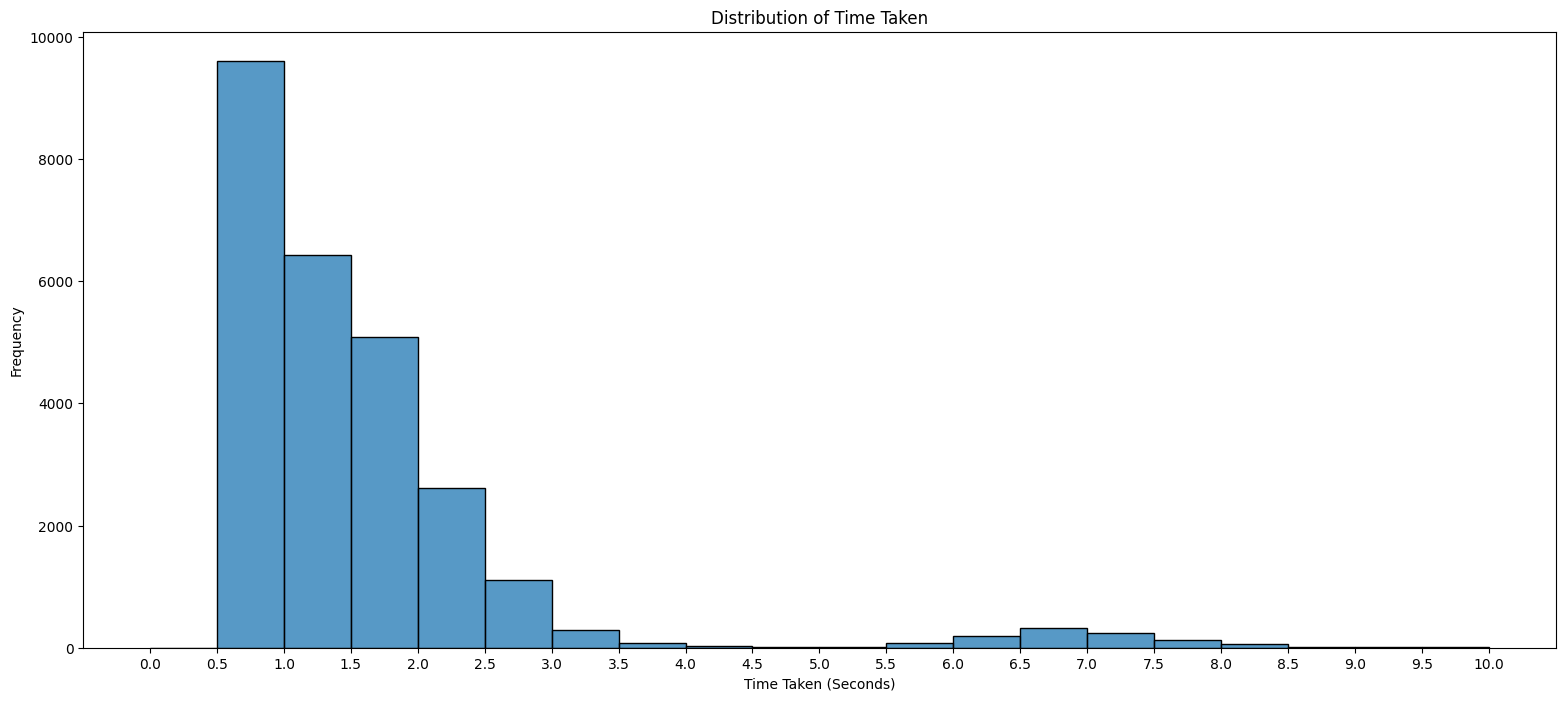

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_traingym99 already has 'Subaction_start' and 'Subaction_end' in seconds
# Calculate the time difference and create a new column 'time_taken'
df_traingym99['time_taken'] = df_traingym99['Subaction_end'] - df_traingym99['Subaction_start']

# Filter the time taken to be less than or equal to 10 seconds
df_traingym99_filtered = df_traingym99[df_traingym99['time_taken'] <= 10]

# Set bin size for 0.25 seconds
bin_size = 0.5
bins = np.arange(0, df_traingym99_filtered['time_taken'].max() + bin_size, bin_size)

# Plot the distribution of time taken using a bar plot with 0.25s bins
plt.figure(figsize=(19, 8))
sns.histplot(df_traingym99_filtered['time_taken'], kde=False, bins=bins)

# Set title and labels
plt.title('Distribution of Time Taken')
plt.xlabel('Time Taken (Seconds)')
plt.ylabel('Frequency')

# Set x-axis ticks to show the seconds (0.25 increments)
plt.xticks(np.arange(0, df_traingym99_filtered['time_taken'].max() + bin_size, bin_size))

plt.show()


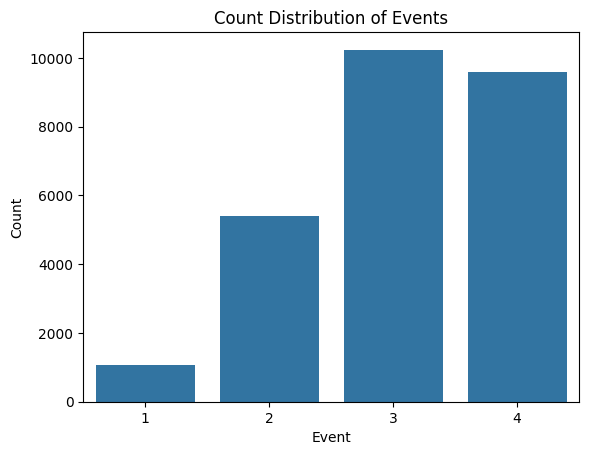

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the count distribution
sns.countplot(data=df_traingym99, x='event')

# Add title and labels
plt.title('Count Distribution of Events')
plt.xlabel('Event')
plt.ylabel('Count')

# Display the plot
plt.show()


## Validation Gym 99 

In [53]:

annotation_file ="<path to jsonfile>/finegym_annotation_info_v1.1.json"
valfile ="<pathtovalidationsplitfile>/gym99_val_element.1.txt"

In [131]:
with open(annotation_file, 'r') as f:
    data=json.load(f)
with open(valfile, 'r') as f:
    val_lines = f.readlines()

lines=val_lines






In [133]:
full_ids=[]
classes=[]
video_ids=[]
Event_start_times=[]
Event_end_times=[]
Subaction_start_times=[]
Subaction_end_times=[]
#videoname=[]
events=[]
stages=[]


count=0
for line in lines:
    full_id = line.split(" ")[0]
    full_ids.append(full_id)
    
    label = int(line.split(" ")[1])
    classes.append(label)

   


    
    video_id = full_id.split("_E_")[0]
    video_ids.append(video_id)
    
    
    eventonly_id=extract_eventsegment(full_id)
    eventtimestamps=data[video_id][eventonly_id]["timestamps"]
    start_event=eventtimestamps[0][0]
    end_event=eventtimestamps[0][1]
    Event_start_times.append(start_event)
    Event_end_times.append(end_event)

    
    event=data[video_id][eventonly_id]["event"]
    events.append(event)
    
    actiononlyid=extract_Action_segment(full_id)
    actiontimestamps=data[video_id][eventonly_id]["segments"][actiononlyid]["timestamps"]
    
    stageaction=data[video_id][eventonly_id]["segments"][actiononlyid]["stages"]
    stages.append(stageaction)
        
    if stageaction==3:   # action has 3 stages
        #print("length is :",len(actiontimestamps))
        startaction=actiontimestamps[0][0]+start_event
        Subaction_start_times.append(startaction)
        endaction=actiontimestamps[2][1]+start_event
        Subaction_end_times.append(endaction)
        
        
        


    if stageaction==1:
        startaction=actiontimestamps[0][0]+start_event
        Subaction_start_times.append(startaction)
        endaction=actiontimestamps[0][1]+start_event
        Subaction_end_times.append(endaction)



In [135]:
columns = ["full_id", "class", "Event_start_time","event", "Event_end_time", "Subaction_start", "Subaction_end", "videoname","stages"]
df_valgym99 = pd.DataFrame({
    "full_id": full_ids,
    "class": classes,
    "event": events,
    "Event_start_time": Event_start_times,
    "Event_end_time": Event_end_times,
    "Subaction_start": Subaction_start_times,
    "Subaction_end": Subaction_end_times,
    "videoname": video_ids,
    "stages": stages
})



In [137]:
df_valgym99.shape

(8521, 9)

In [139]:
df_valgym99.to_csv("val99.csv", index=False)

'C:\\Users\\Hassani\\Downloads'